In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor 

from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_csv('Monthly_oil_data.csv', index_col='Production Date', parse_dates=True)

In [3]:
df.head()

,Volume
Production Date,
2015-01-01,67515553.0
2015-02-01,61664960.0
2015-03-01,66342950.0
2015-04-01,67719040.0
2015-05-01,66484591.0


### Differencing

In [4]:
df['DiffVolume'] = df['Volume'].diff() 

In [5]:
df.head()

,Volume,DiffVolume
Production Date,,
2015-01-01,67515553.0,NaN
2015-02-01,61664960.0,-5850593.0
2015-03-01,66342950.0,4677990.0
2015-04-01,67719040.0,1376090.0
2015-05-01,66484591.0,-1234449.0


### Supervised Dataset

In [6]:
series = df['DiffVolume'].to_numpy()[1:] 

T = 12
X = [] 
Y = []  
for t in range(len(series) - T):
    x = series[t:t+T] 
    X.append(x) 
    y = series[t+T] 
    Y.append(y)

X = np.array(X).reshape(-1, T) 
Y = np.array(Y) 
N = len(X) 
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (112, 12) Y.shape (112,)


### Train Test Split

In [7]:
Ntest = 12  
train = df.iloc[:-Ntest] 
test = df.iloc[-Ntest:] 

Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest] 
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

### Indexing

In [8]:
train_idx = df.index <= train.index[-1]  
test_idx = ~train_idx 

train_idx[:T+1] = False # first T+1 values are not predictable

In [9]:
df['ShiftVolume'] = df['Volume'].shift(1) 
prev = df['ShiftVolume']

In [10]:
# Last-known train value 
last_train = train.iloc[-1]['Volume']

### 1-step and Multi-step forecast

In [11]:
def one_step_and_multistep_forecast(model, name): 
    model.fit(Xtrain, Ytrain) 
    print('One-step forecast:', name) 
    print('Train R^2 (1-step):', model.score(Xtrain, Ytrain))
    print('Test R^2 (1-step):', model.score(Xtest, Ytest))

    #store 1-step forecast 
    df.loc[train_idx, f'{name}_1step_train'] = prev[train_idx] + model.predict(Xtrain) 
    df.loc[test_idx, f'{name}_1step_test'] = prev[test_idx] + model.predict(Xtest) 
    
    #generate multi-step forecast
    multistep_predictions = [] 

    #first test input 
    last_x = Xtest[0] 

    while len(multistep_predictions) < Ntest: 
        p = model.predict(last_x.reshape(1, -1))[0] 

        #update the predictions list 
        multistep_predictions.append(p)  

        #make the new input 
        last_x = np.roll(last_x, -1) 
        last_x[-1] = p 

    #store multi-step forecast 
    df.loc[test_idx, f'{name}_multistep_test'] = last_train + np.cumsum(multistep_predictions)

    #RMSE of multi-step forecast 
    test_log_pass = df.iloc[-Ntest:]['Volume']
    rmse = np.sqrt(mean_squared_error(test_log_pass, df.loc[test_idx, f'{name}_multistep_test'])) 
    print('Test RMSE (multi-step):', rmse) 

    #plot 1-step and multi-step forecast 
    cols = ['Volume', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test']
    df.iloc[-100:][cols].plot(figsize=(15,5));

One-step forecast: LR
Train R^2 (1-step): 0.40508287171815427
Test R^2 (1-step): 0.592729349323144
Test RMSE (multi-step): 7683804.828381825


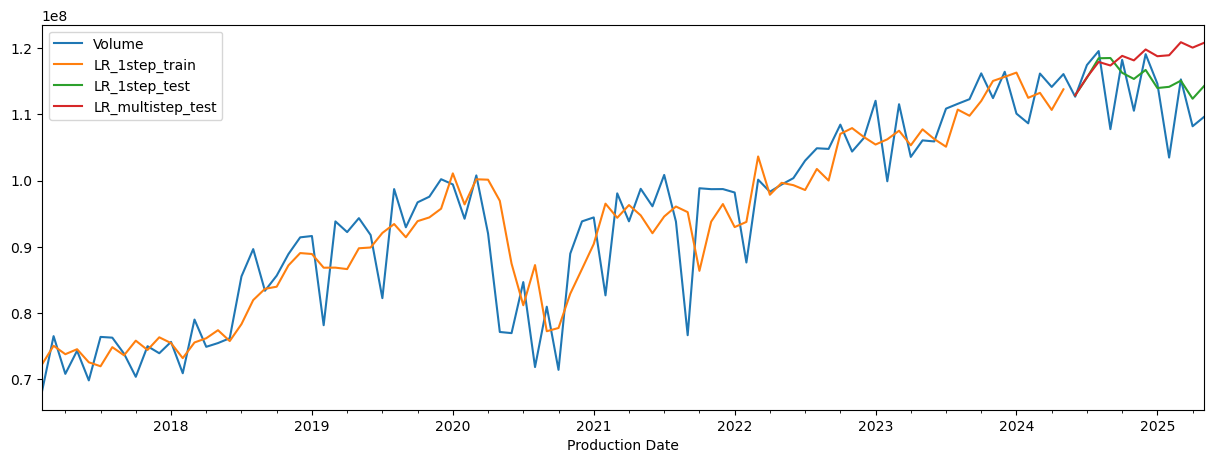

In [12]:
one_step_and_multistep_forecast(LinearRegression(), 'LR')

One-step forecast: SVR
Train R^2 (1-step): -0.0011419357925328555
Test R^2 (1-step): -0.02426577503593319
Test RMSE (multi-step): 9859644.091901354


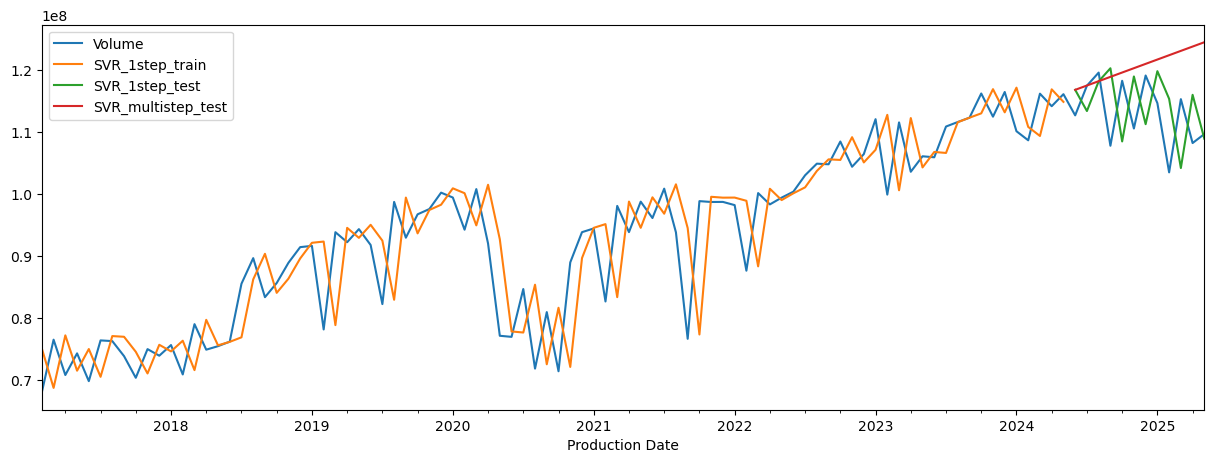

In [13]:
one_step_and_multistep_forecast(SVR(), 'SVR')

One-step forecast: RF
Train R^2 (1-step): 0.8958753975676964
Test R^2 (1-step): 0.419023800669022
Test RMSE (multi-step): 7563279.007517529


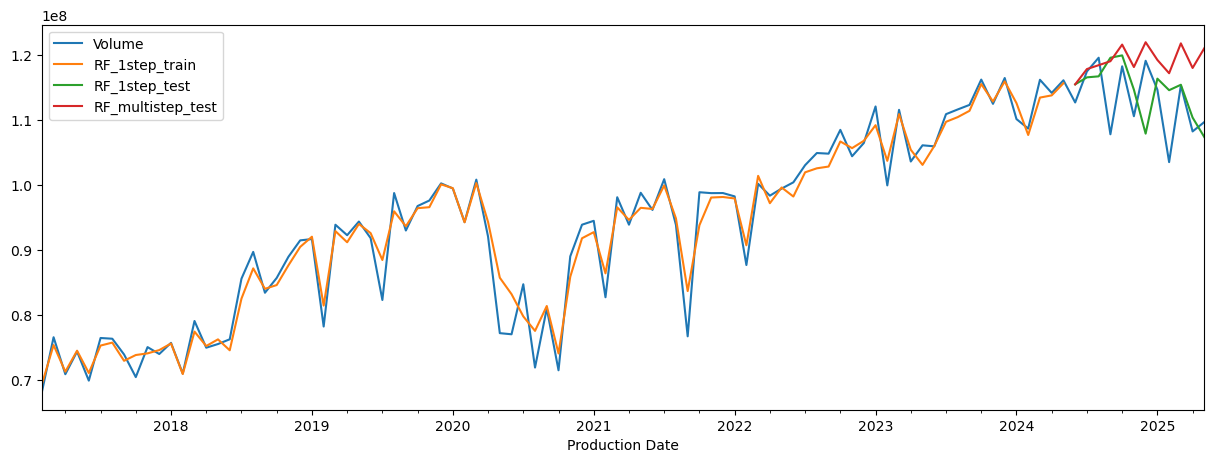

In [14]:
one_step_and_multistep_forecast(RandomForestRegressor(), 'RF')

### Multi- output supervised dataset

In [15]:
Tx = T 
Ty = Ntest 
X = [] 
Y = [] 

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx] 
    X.append(x) 
    y = series[t+Tx:t+Tx+Ty] 
    Y.append(y) 

X = np.array(X).reshape(-1, Tx) 
Y = np.array(Y).reshape(-1, Ty) 
N = len(X) 
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (101, 12) Y.shape (101, 12)


In [16]:
Xtrain_m, Ytrain_m =  X[:-1], Y[:-1]  
Xtest_m, Ytest_m = X[-1:], Y[-1:]

### Multi-output forecast

In [17]:
def multi_output_forecast(model, name): 
    model.fit(Xtrain_m, Ytrain_m) 

    #save multi-output forecast to dataframe 
    df.loc[test_idx, f'{name}_multioutput'] = last_train + np.cumsum(model.predict(Xtest_m).flatten()) 

    test_log_pass = df.iloc[-Ntest:]['Volume']
    rmse = np.sqrt(mean_squared_error(test_log_pass, df.loc[test_idx, f'{name}_multioutput'])) 
    print('Test RMSE (multi-output):', rmse) 

    #plot all forecasts 
    cols = ['Volume', f'{name}_1step_train', f'{name}_1step_test',
            f'{name}_multistep_test', f'{name}_multioutput',]
    df.iloc[-100:][cols].plot(figsize=(15,5));

Test RMSE (multi-output): 7351691.033927572


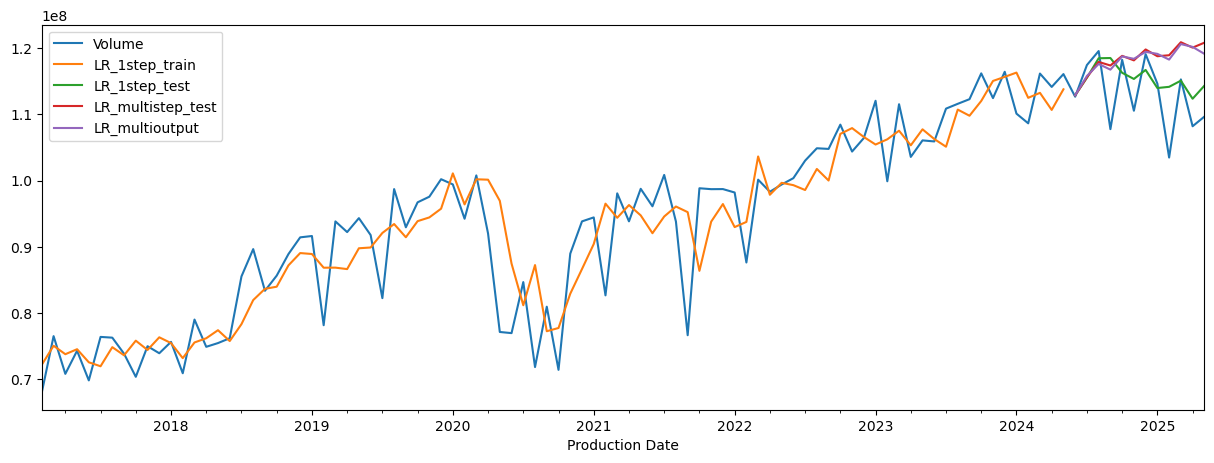

In [18]:
multi_output_forecast(LinearRegression(), 'LR')

Test RMSE (multi-output): 7099123.848785624


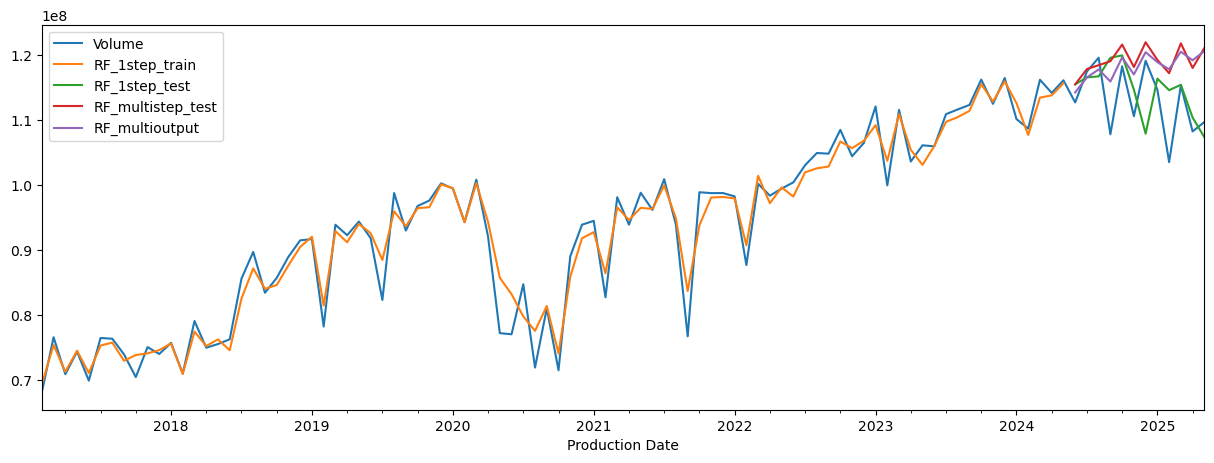

In [19]:
multi_output_forecast(RandomForestRegressor(), 'RF')

In [20]:
class SVRWrapper: 
    def __init__(self, h, **args): 
        self.h = h 
        self.models = [SVR(**args) for _ in range(h)] 

    def fit(self, X, Y): 
        for k in range(self.h): 
            self.models[k].fit(X, Y[:, k]) 

    def predict(self, X): 
        P = [m.predict(X) for m in self.models] 
        return np.hstack(P)

Test RMSE (multi-output): 9858765.053436777


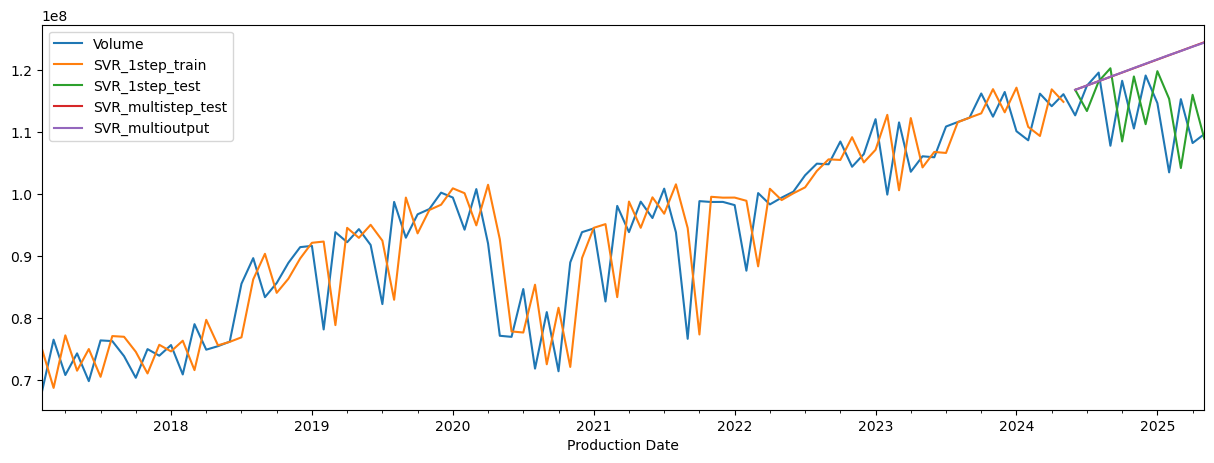

In [21]:
multi_output_forecast(SVRWrapper(Ntest), 'SVR')

### Conclusion

Linear Regression and Random Forest Regression models perform comparatively similarly with Random Forest multi-output forecast having the lowest RMSE at  7099123.85